In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [108]:
# global parameters

L = 30             # side length
N = L ** 2        # number of sites
q = 2             # number of states per site

In [109]:
# energy function of the potts model with long-range interactions.
def energy(sigma, J):
    # initialize energy to 0
    en = 0
    # loop over sites
    for i in range(N):
        # interaction mask of site i: True at position j iff site i and site j interact.
        delta = (sigma[i] == sigma)
        delta[i] = False
        # energy due to interaction of i with all other sites --> double counting non-diagonal entries
        en += np.dot(J[i], delta)

    # fix double counting before returning
    return 0.5 * en / N

# slow but safe implementation of the energy
def energy_test(sigma, J):
    # initialize energy to 0
    en = 0
    # loop over pairs of sites
    for i in range(N):
        for j in range(i + 1, N):
            # add interaction of sites i and j
            if sigma[i] == sigma[j]:
                en += J[i, j]
    return en / N

In [110]:
# propose a random flip in a random site
def propose_flip(sigma, J):
    # sample a random site and state
    index = np.random.randint(0, N)
    x = np.random.randint(0, q)
    # ensure new state is different than the old one
    while x == sigma[index]:
        x = np.random.randint(0, q)
    # return
    return index, x

In [111]:
# compute change in energy after flipping site i to state new_q
def delta_energy(sigma, J, i, new_q):

    # interaction masks of site i before and after flip
    delta_old = (sigma == sigma[i])
    delta_new = (sigma == new_q)
    delta_new[i], delta_old[i] = False, False

    # energy due to interactions that stop happening after flip
    en_old = np.dot(J[i], delta_old)
    # energy due to interactions that begin happening after flip
    en_new = (np.dot(J[i], delta_new))

    # return change in energy due to flip
    return (en_new - en_old) / N

In [112]:
# metropolis acceptance with symmetric proposal. returns a Boolean
def metropolis(delta_en, t):
    if delta_en < 0:
        return True
    if np.random.uniform(0, 1) < np.exp( - delta_en / t ):
        return True
    return False

In [113]:
# # random symmetric interaction matrix.
# J = np.random.randn(N, N)
# for i in range(N):
#     for j in range(i+1, N):
#         J[i, j] = J[j, i]

# # random nearest-neighbour interaction matrix
# J = np.zeros((N, N))
# assert np.sqrt(N) == int(np.sqrt(N))    # N must be a perfect square
# for i in range(N):
#     for j in [(i//L)*L + (i+1)%L, (i//L)*L + (i-1)%L, ((i//L+1)%L)*L + i%L, ((i//L-1)%L)*L + i%L]:
#         J[i, j] = np.random.randn()

# ferromagnetic interaction
J = - np.ones((N, N))

In [106]:
# Monte Carlo simulation

# random initial configuration
sigma = np.random.randint(0, q, N)

t = 0.5
nstep = 10000
stride = 1000

en = energy(sigma, J)
en_history = []
mag_history = np.zeros((q, nstep))
prob_history = []
n_accepted = 0

for istep in range(nstep):

    # propose random flip
    ind, q_new = propose_flip(sigma, J)
    # compute energy difference
    delta_en = delta_energy(sigma, J, ind, q_new)

    # update probability history
    if delta_en > 0:
        prob_history.append(min(1, np.exp(- delta_en / t)))

    # metropolis update rule
    if metropolis(delta_en, t):
        # update state
        sigma[ind] = q_new
        n_accepted += 1

        # update energy
        en += delta_en

    # update history
    en_history.append(en)
    mag_history[:, istep] = np.bincount(sigma)

    if istep % stride == 0:
        print(istep, en)

en_history = np.array(en_history)

0 -224.90111111111113
1000 -225.25111111111113
2000 -228.3677777777778
3000 -230.91777777777781
4000 -226.75000000000003
5000 -227.27777777777783
6000 -226.3677777777778
7000 -226.2777777777778
8000 -226.02111111111114
9000 -228.77111111111114


Average energy: -227.42066388888895


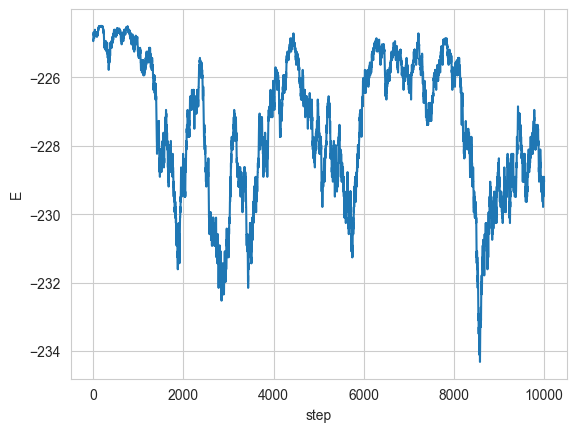

In [107]:
plt.plot(en_history)
plt.xlabel("step")
plt.ylabel("E")
print(f'Average energy: {en_history.mean()}')
plt.show()

Fraction of accepted proposals: 0.9272


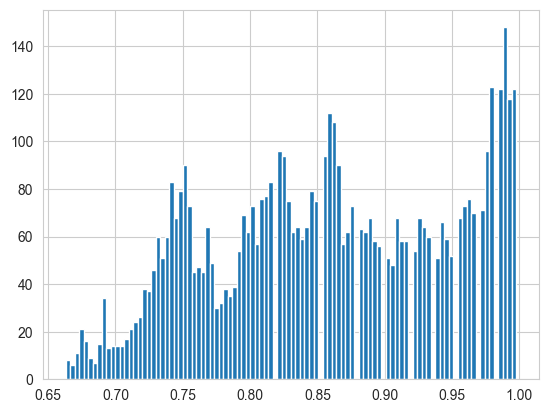

In [103]:
print(f"Fraction of accepted proposals: {n_accepted / nstep}")
plt.hist(prob_history, bins=100)
plt.show()

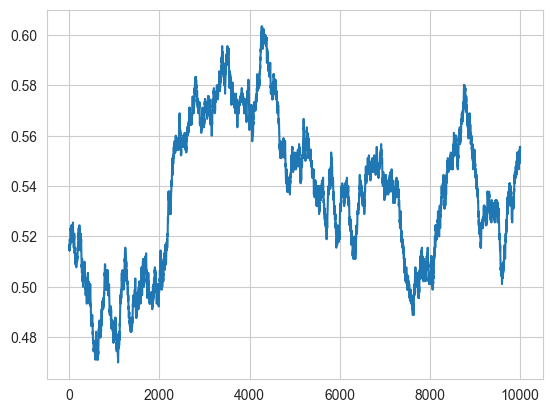

In [104]:
plt.plot(mag_history[0] / N)
plt.show()